In [3]:
### Imports 

import numpy as np
import matplotlib.pyplot as plt 
import os
import healpy as hp 
import pysm3
import pysm3.units as u
import pickle
from fgspectra import frequency as fgf
from fgspectra import power as fgp
from fgspectra import cross as fgc
from getdist import loadMCSamples, plots
import scipy.stats as sts

In [8]:
### CONSTANTS ###

nside = 4096
lmax = 10000
FREQS_PLANCK = np.array([143,217,353,545])
flux_list_planck = [350,225,315,350]
ell_0=3000
ell = np.linspace(0,lmax,lmax+1).astype('int')
todl = ell*(ell+1)/2/np.pi

PATH = "/Users/benjaminberingue/Documents/Research/Foregrounds/data/"

def get_spectra_agora(freq, lmax = 10000, dl=False, units='Jy'):
    if freq not in [143,217]:
        print(f"{freq} not available for Agora simulations")
        return None, None
    fname = os.path.join(PATH, 'Agora', "cls_mdpl2_v0.7_cib_planck_{:d}ghz.dat".format(int(freq)))
    ell, cl = np.loadtxt(fname, unpack=True)
    if units == 'Jy':
        m = np.ones(1) * u.uK_CMB
        to_Jy = m.to(u.jansky/u.sr, equivalencies=u.cmb_equivalencies(freq*u.GHz)).value[0]
        cl = cl * to_Jy **2 
    if dl:
        cl = ell*(ell+1)/2./np.pi * cl
    return ell[:lmax], cl[:lmax]


def get_spectra_websky(freq, lmax = 10000, dl=False, units='Jy'):
    if freq not in [143,217,353,545]:
        print(f"{freq} not available for websky simulations")
        return None, None
    with open(os.path.join(PATH, "cl_cib_Jysr_nside4096_v04.pick"), "rb") as f:
        cl_cib_websky = pickle.load(f)
        cl = cl_cib_websky[np.argwhere(FREQS_PLANCK == freq)][0,0]
        ell = np.arange(len(cl))
    if units == 'uK_CMB':
        m = np.ones(1)
        m = m * u.jansky/u.sr
        to_uK_CMB = m.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(f*u.GHz)).value[0]
        cl = cl * to_uK_CMB **2 
    if dl:
        cl = ell*(ell+1)/2./np.pi * cl
    return ell[:lmax], cl[:lmax]*1e12

samples = loadMCSamples("../DR6_modelling/outputs/chains/MBAC_reichardt_plik_fixedcosmo", settings={'ignore_rows':0.3})
def draw_params(bf=True, samples=samples):
    param_dict = samples.getParamBestFitDict()
    params = ["a_CIB", "a_CIBp", "T_dp", "beta_p", "beta_c"]
    cov = samples.cov(pars=params)
    mean = [param_dict["a_CIB"], param_dict["a_CIBp"], param_dict["T_dp"], param_dict["beta_p"], param_dict["beta_c"]]
    if bf: 
        return param_dict
    else:
        res = sts.multivariate_normal(mean=mean, cov=cov).rvs()
        dict_res = param_dict.copy()
        for i, key in enumerate(params):
            dict_res[key] = res[i]
        return dict_res

def get_MBAC_recihardt_plik_bf(freq, param_dict, lmax=10000, dl=False, units='Jy' ):
    ell = np.linspace(0,lmax, lmax+1).astype('int')
    #cibc
    cibc_template = fgp._get_power_file("cib_planck_highL")
    cibc = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(),fgp.PowerSpectrumFromFile(cibc_template))
    cibc_params={'sed_kwargs':{'nu': freq, 'nu_0':150., 'temp':9.4, 'beta':param_dict['beta_c']}, 
                   'cl_kwargs': {'ell':ell, 'ell_0':3000, 'amp':param_dict['a_CIB']}}
    #cibp
    cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
    cibp_params={'sed_kwargs':{'nu':freq, 'nu_0':150., 'temp':25., 'beta':param_dict['beta_p']}, 
                   'cl_kwargs': {'ell':ell*(ell+1), 'ell_0':3000*3001, 'alpha':1.,'amp':param_dict['a_CIBp']}}
    dl_template = cibc.eval(**cibc_params) + cibp.eval(**cibp_params)
    if dl:
        cl_template = dl_template
    else:
        cl_template = dl_template / ell /(ell+1) * 2. * np.pi
    if units == 'Jy':
        m = np.ones(1) * u.uK_CMB
        to_Jy = m.to(u.jansky/u.sr, equivalencies=u.cmb_equivalencies(freq*u.GHz)).value[0]
        cl_template = cl_template * to_Jy **2 
    return ell[:lmax], cl_template[0,0,:lmax]

/var/folders/jj/zmth4r4x6m9185fq4zh2375h0000gq/T/ipykernel_32792/1199828718.py:75: RuntimeWarning: invalid value encountered in true_divide
  cl_template = dl_template / ell /(ell+1) * 2. * np.pi


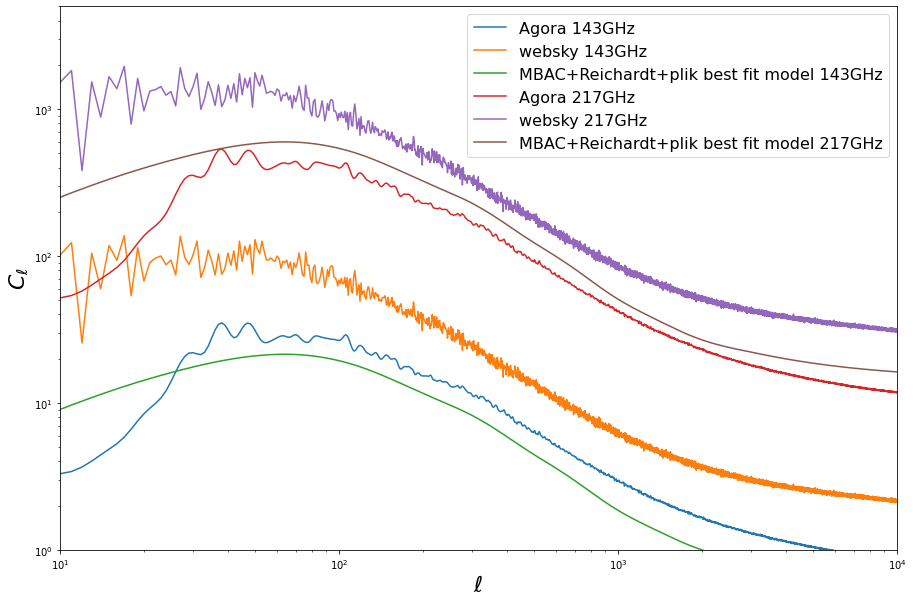

In [42]:
f, ax = plt.subplots(1,1,figsize=(15,10))

for i, fr in enumerate([143,217]):
    ell, cl = get_spectra_agora(fr)
    ax.plot(ell, cl, label = f"Agora {fr}GHz")
    ell, cl = get_spectra_websky(fr)
    ax.plot(ell, cl, label = f"websky {fr}GHz")
    ell, cl = get_MBAC_recihardt_plik_bf(fr,draw_params())
    ax.plot(ell, cl, label = f"MBAC+Reichardt+plik best fit model {fr}GHz")
ax.legend(loc = 'best', prop={'size':16})
ax.set_xlabel('$\ell$', fontsize = 22)
ax.set_ylabel('$C_{\ell}$', fontsize = 22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 10000)
ax.set_ylim(1,5e3)
# plt.savefig("../../../ACT/project/0223_mflike-highL/DR6_fgmodels/figures/agora_websky.png")
plt.show()

/var/folders/jj/zmth4r4x6m9185fq4zh2375h0000gq/T/ipykernel_1788/1199828718.py:75: RuntimeWarning: invalid value encountered in true_divide
  cl_template = dl_template / ell /(ell+1) * 2. * np.pi


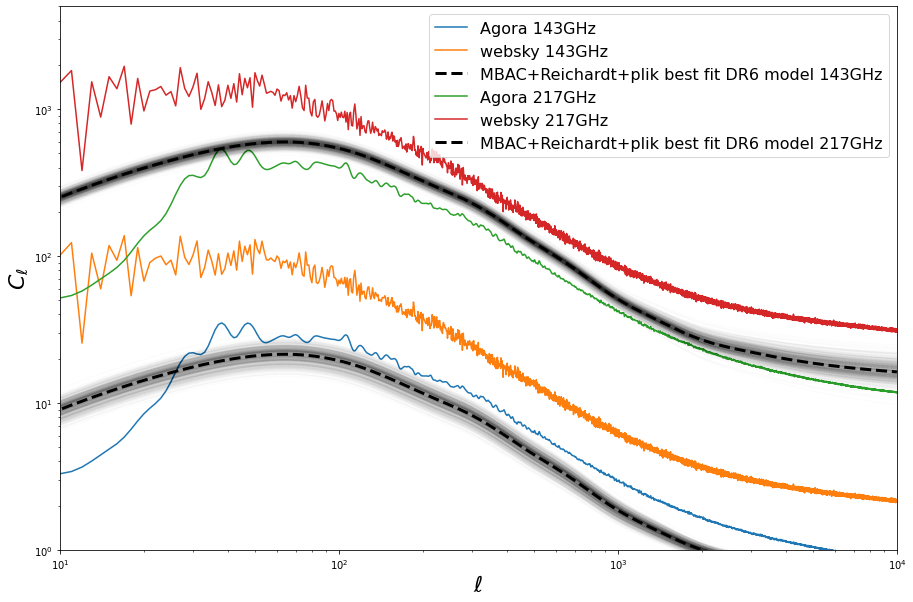

In [9]:
f, ax = plt.subplots(1,1,figsize=(15,10))
N = 500
for i, fr in enumerate([143,217]):
    ell, cl = get_spectra_agora(fr)
    ax.plot(ell, cl, label = f"Agora {fr}GHz")
    ell, cl = get_spectra_websky(fr)
    ax.plot(ell, cl, label = f"websky {fr}GHz")
    for _ in range(N):
        ell, cl = get_MBAC_recihardt_plik_bf(fr, draw_params(False))
        ax.plot(ell, cl, alpha=.01, c='k')
    ell, cl = get_MBAC_recihardt_plik_bf(fr,draw_params())
    ax.plot(ell, cl, label = f"MBAC+Reichardt+plik best fit DR6 model {fr}GHz", lw=3, c='k', ls='dashed')
ax.legend(loc = 'best', prop={'size':16})
ax.set_xlabel('$\ell$', fontsize = 22)
ax.set_ylabel('$C_{\ell}$', fontsize = 22)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10, 10000)
ax.set_ylim(1,5e3)
plt.savefig("../figures/agora_websky_bfdr6_plcmask.png")
plt.show()